In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.375 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

250000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

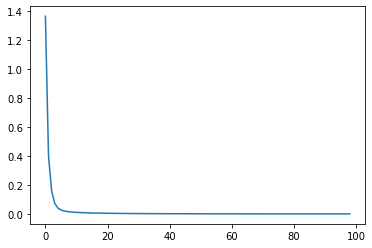

In [8]:
plt.plot(S)

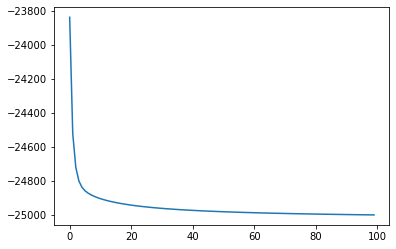

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0004464130660344381

In [11]:
eta

array([-23837.13426666, -24520.7262481 , -24720.09440179, -24799.9486425 ,
       -24836.8926966 , -24857.48440447, -24871.32988545, -24881.8197973 ,
       -24890.33304186, -24897.5345628 , -24903.79141387, -24909.32775904,
       -24914.29136776, -24918.78556708, -24922.88603597, -24926.65029111,
       -24930.12336958, -24933.34140463, -24936.33397131, -24939.12568136,
       -24941.73730178, -24944.1865612 , -24946.48874513, -24948.65714503,
       -24950.70340339, -24952.63778352, -24954.46938362, -24956.20630898,
       -24957.85581208, -24959.42440796, -24960.91796997, -24962.34181009,
       -24963.70074674, -24964.99916245, -24966.24105324, -24967.43007113,
       -24968.56956099, -24969.6625925 , -24970.71198815, -24971.72034776,
       -24972.69007009, -24973.62337193, -24974.522305  , -24975.38877098,
       -24976.22453497, -24977.0312374 , -24977.81040481, -24978.56345947,
       -24979.29172809, -24979.99644957, -24980.67878214, -24981.33980972,
       -24981.98054773, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([1.16226573e+03, 4.78673753e+02, 2.79305599e+02, 1.99451358e+02,
       1.62507304e+02, 1.41915596e+02, 1.28070115e+02, 1.17580203e+02,
       1.09066959e+02, 1.01865438e+02, 9.56085867e+01, 9.00722416e+01,
       8.51086328e+01, 8.06144335e+01, 7.65139646e+01, 7.27497095e+01,
       6.92766310e+01, 6.60585960e+01, 6.30660293e+01, 6.02743192e+01,
       5.76626988e+01, 5.52134394e+01, 5.29112555e+01, 5.07428556e+01,
       4.86965972e+01, 4.67622171e+01, 4.49306170e+01, 4.31936916e+01,
       4.15441885e+01, 3.99755926e+01, 3.84820306e+01, 3.70581905e+01,
       3.56992539e+01, 3.44008381e+01, 3.31589474e+01, 3.19699295e+01,
       3.08304396e+01, 2.97374081e+01, 2.86880125e+01, 2.76796528e+01,
       2.67099305e+01, 2.57766287e+01, 2.48776956e+01, 2.40112296e+01,
       2.31754656e+01, 2.23687632e+01, 2.15895958e+01, 2.08365411e+01,
       2.01082725e+01, 1.94035510e+01, 1.87212185e+01, 1.80601909e+01,
       1.74194529e+01, 1.67980523e+01, 1.61950953e+01, 1.56097423e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_14.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_14.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_14.csv', S, delimiter = ',')